A metric that checks how many nights we have color information on a potential transient

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class NnightsWColor(metrics.BaseMetric):
    """See how many nights a spot is observed at least twice in one filter and once in another.
    
    Parameters
    ----------
    n_in_one : int (2)
       The number of observations in a single filter to require
    n_filts : int (2)
       The number of unique filters to demand
    filters : list 
       The list of acceptable filters
    
    """
    def __init__(self, metricName='', mjdCol='expMJD',
                 filterCol='filter', nightCol='night', n_in_one=2, n_filts=2, 
                 filters=None, **kwargs):
        if filters is None:
            self.filters = ['u', 'g', 'r', 'i', 'z', 'y']
        else:
            self.filters = filters
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol
        self.n_in_one = n_in_one
        self.n_filts = n_filts
        super(NnightsWColor, self).__init__(col=[self.mjdCol, self.nightCol,
                                                 self.filterCol],
                                            units='# Nights',
                                            metricName=metricName,
                                            **kwargs)
        
    def run(self,  dataSlice, slicePoint=None):
        
        night_bins = np.arange(dataSlice[self.nightCol].min()-.5, dataSlice[self.nightCol].max()+2.5, 1)
        all_obs = np.zeros((night_bins.size-1, len(self.filters)))
        for i, filtername in enumerate(self.filters):
            good = np.where(dataSlice[self.filterCol] == filtername)
            hist, edges = np.histogram(dataSlice[self.nightCol][good], bins=night_bins)
            all_obs[:,i] += hist
        # max number of observations in a single filter per night
        max_collapse = np.max(all_obs, axis=1)
        all_obs[np.where(all_obs > 1)] = 1
        # number of unique filters per night
        n_filt = np.sum(all_obs, axis=1)
        good = np.where((max_collapse >= self.n_in_one) & (n_filt >= self.n_filts))[0]
        return np.size(good)

In [3]:
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'TransientsUPS'
resultsDb = db.ResultsDb(outDir=outDir)

In [4]:
metric = NnightsWColor()
sql = ''
slicer = slicers.HealpixSlicer()
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [5]:
bundleList = [bundle]
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  ['minion_1016_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 523 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:177: UserWarning: XXX-Not removing dipole, need healpy updated on python 3 first
  warnings.warn('XXX-Not removing dipole, need healpy updated on python 3 first')


Plotting complete.


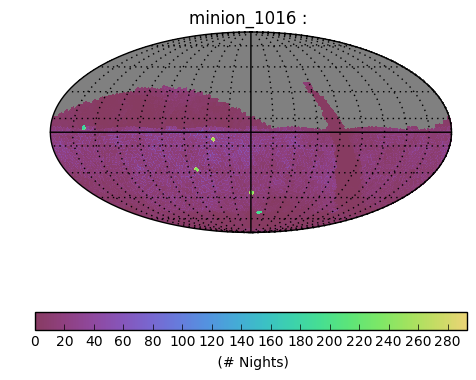

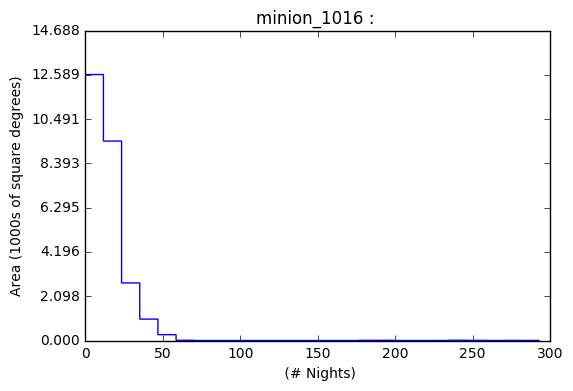

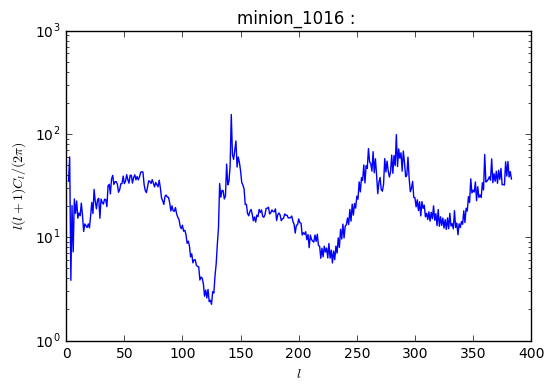

In [6]:
bgroup.plotAll(closefigs=False)